In [9]:
# Dependencies
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [30]:
# Load in data
uni_ar_lstm = pd.read_csv('uni_ar_lstm.csv') # univariate autoregressive lstm
lstm = pd.read_csv('lstm.csv') # lstm
ar = pd.read_csv('ar.csv') # autoregressive
var = pd.read_csv('var.csv') # vector autoregressive
# Remote all error greater than 5
uni_ar_lstm = uni_ar_lstm[uni_ar_lstm['rmse'] < 5]
lstm = lstm[lstm['rmse'] < 5]
ar = ar[ar['rmse'] < 5]
ar = ar[ar['horizon'].isin([4, 16, 28, 40, 52])]
ar = ar[ar['lags'].isin([1, 2, 4, 6, 12, 24])]
var = var[var['rmse'] < 5]

# Get the minimum error for each forecast horizon
uni_ar_lstm_min = uni_ar_lstm.groupby('forecast_horizon')['rmse'].min().reset_index()
lstm_min = lstm.groupby('forecast_horizon')['rmse'].min().reset_index()
ar_min = ar.groupby('horizon')['rmse'].min().reset_index()
var_min = var.groupby('forecast_horizon')['rmse'].min().reset_index()

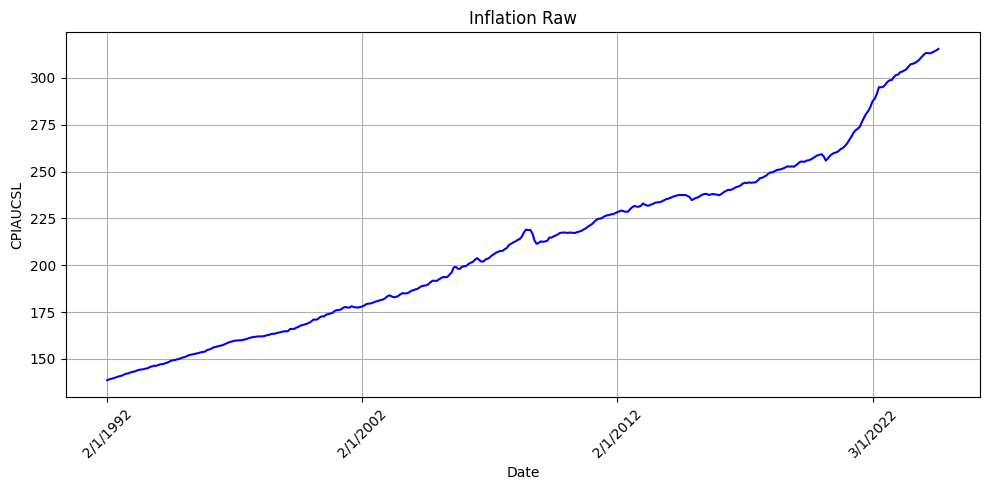

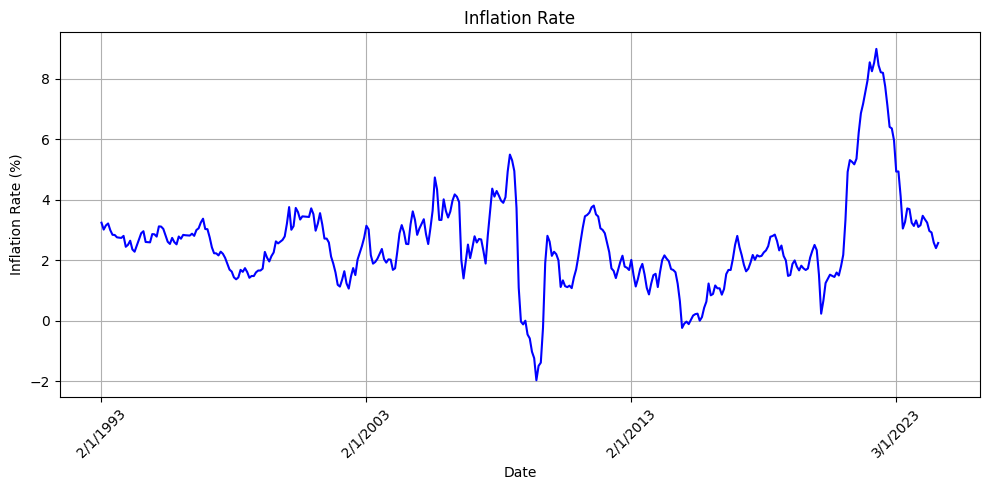

In [31]:
import matplotlib.dates as mdates

# Visualize inflation 
inflation_raw = pd.read_csv('../current.csv', index_col=0)[1:].dropna()["CPIAUCSL"]
inflation_rate = (inflation_raw.pct_change(periods=12) * 100).dropna()

# Plot inflation raw
plt.figure(figsize=(10, 5))
plt.plot(inflation_raw, color='blue')
plt.title('Inflation Raw')
plt.xlabel('Date')
plt.ylabel('CPIAUCSL')
# Show a label every 10 years
x_labels = [inflation_raw.index[i] for i in range(0, len(inflation_raw), 120)]
plt.xticks(x_labels, rotation=45)
plt.grid()
plt.tight_layout()
plt.show()
plt.close()

# Plot inflation rate
plt.figure(figsize=(10, 5))
plt.plot(inflation_rate, color='blue')
plt.title('Inflation Rate')
plt.xlabel('Date')
plt.ylabel('Inflation Rate (%)')
# Format x-axis
x_labels = [inflation_rate.index[i] for i in range(0, len(inflation_rate), 120)]
plt.xticks(x_labels, rotation=45)
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()
plt.show()
plt.close()

In [32]:
# Check stationarity
from statsmodels.tsa.stattools import adfuller

inflation_stat = adfuller(inflation_raw.dropna())
print(f"ADF Statistic: {inflation_stat[0]:.3f}")
print(f"p-value: {inflation_stat[1]:.3f}")
inflation_rate_stat = adfuller(inflation_rate.dropna())
print(f"ADF Statistic: {inflation_rate_stat[0]:.3f}")
print(f"p-value: {inflation_rate_stat[1]:.3f}")

ADF Statistic: 1.372
p-value: 0.997
ADF Statistic: -3.435
p-value: 0.010


In [33]:
# Get the hyperparameters for the best model
uni_ar_lstm_best = uni_ar_lstm.loc[uni_ar_lstm['rmse'].idxmin()]
lstm_best = lstm.loc[lstm['rmse'].idxmin()]
ar_best = ar.loc[ar['rmse'].idxmin()]
var_best = var.loc[var['rmse'].idxmin()]
# Drop last two rows
uni_ar_lstm_best = uni_ar_lstm_best[:-2]
lstm_best = lstm_best[:-2]
ar_best = ar_best[:-2]
var_best = var_best[:-2]
# Print the hyperparameters
print("Univariate Autoregressive LSTM Best Hyperparameters:")
print(uni_ar_lstm_best)
print("\nLSTM Best Hyperparameters:")
print(lstm_best)
print("\nAutoregressive Best Hyperparameters:")
print(ar_best)
print("\nVector Autoregressive Best Hyperparameters:")
print(var_best)

Univariate Autoregressive LSTM Best Hyperparameters:
forecast_horizon           4
context_window            24
dropout_rate             0.1
rmse                0.259941
mae                  0.21798
Name: 21, dtype: object

LSTM Best Hyperparameters:
forecast_horizon           4
context_window             2
dropout_rate             0.3
normalized              True
rmse                0.213193
mae                  0.19154
Name: 7, dtype: object

Autoregressive Best Hyperparameters:
horizon           4
lags             12
rmse       0.108325
mae        0.095604
Name: 80, dtype: object

Vector Autoregressive Best Hyperparameters:
forecast_horizon           4
lags                       4
variance                 0.8
normalized              True
rmse                0.097593
mae                 0.082784
Name: 92, dtype: object


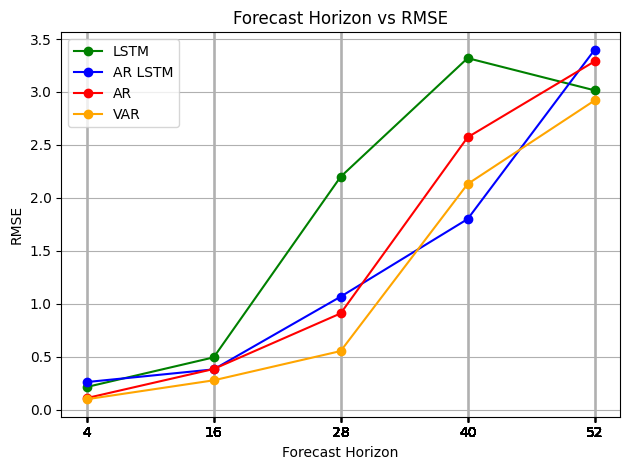

In [34]:
# Visualize minimum RMSE at each forecast horizon
plt.figure()
# Plot the RMSE for each model
# plt.scatter(lstm['forecast_horizon'], lstm['rmse'], marker='o', label="LSTM", color="green")
# plt.scatter(uni_ar_lstm['forecast_horizon'], uni_ar_lstm['rmse'], marker='o', label="Univariate AR LSTM", color="blue")
# plt.scatter(ar['forecast_horizon'], ar['rmse'], marker='o', label="AR", color="red")
# plt.scatter(var['forecast_horizon'], var['rmse'], marker='o', label="VAR", color="orange")
# Plot the minimum RMSE for each model
plt.plot(lstm_min['forecast_horizon'], lstm_min['rmse'], color='green', label='LSTM', marker='o')
plt.plot(uni_ar_lstm_min['forecast_horizon'], uni_ar_lstm_min['rmse'], color='blue', label='AR LSTM', marker='o')
plt.plot(ar_min['horizon'], ar_min['rmse'], color='red', label='AR', marker='o')
plt.plot(var_min['forecast_horizon'], var_min['rmse'], color='orange', label='VAR', marker='o')

plt.title('Forecast Horizon vs RMSE')
plt.xlabel('Forecast Horizon')
plt.ylabel('RMSE')
plt.xticks(lstm['forecast_horizon'])
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

In [22]:
def plot_forecasts(horizon):
    """
    Plot the forecasts for each model at a given horizon (4, 16, 28, 40, 52).
    """
    # Filter the data for the given horizon
    lstm_horizon = lstm[lstm['forecast_horizon'] == horizon]
    uni_ar_lstm_horizon = uni_ar_lstm[uni_ar_lstm['forecast_horizon'] == horizon]
    ar_horizon = ar[ar['horizon'] == horizon]
    var_horizon = var[var['forecast_horizon'] == horizon]
    # Get the best forecast for each model
    lstm_horizon = lstm_horizon[lstm_horizon['rmse'] == lstm_horizon['rmse'].min()]
    uni_ar_lstm_horizon = uni_ar_lstm_horizon[uni_ar_lstm_horizon['rmse'] == uni_ar_lstm_horizon['rmse'].min()]
    ar_horizon = ar_horizon[ar_horizon['rmse'] == ar_horizon['rmse'].min()]
    var_horizon = var_horizon[var_horizon['rmse'] == var_horizon['rmse'].min()]
    # Get the forecast values
    lstm_forecast = np.array(eval(lstm_horizon['forecast'].values[0]))
    uni_ar_lstm_forecast = np.array(eval(uni_ar_lstm_horizon['forecast'].values[0]))
    ar_forecast = np.array(eval(ar_horizon['forecast'].values[0]))
    var_forecast = np.array(eval(var_horizon['forecast'].values[0]))

    # Get the actual values
    actual = np.array(eval(lstm_horizon['actual'].values[0]))

    # Plot the forecasts
    plt.figure(figsize=(8, 8))
    plt.plot(lstm_forecast, label='LSTM', color='green')
    plt.plot(uni_ar_lstm_forecast, label='Univariate AR LSTM', color='blue')
    plt.plot(ar_forecast, label='AR', color='red')
    plt.plot(var_forecast, label='VAR', color='orange')
    plt.plot(actual, label='Actual', color='black', linestyle='--')

    # Set X axis as whole numbers
    index = np.arange(len(lstm_forecast))
    plt.xticks(index, index)
    plt.xlim(0, len(lstm_forecast) - 1)    

    plt.title(f'Forecasts at Horizon {horizon}')
    plt.xlabel('Time')
    plt.ylabel('Forecast Value')
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

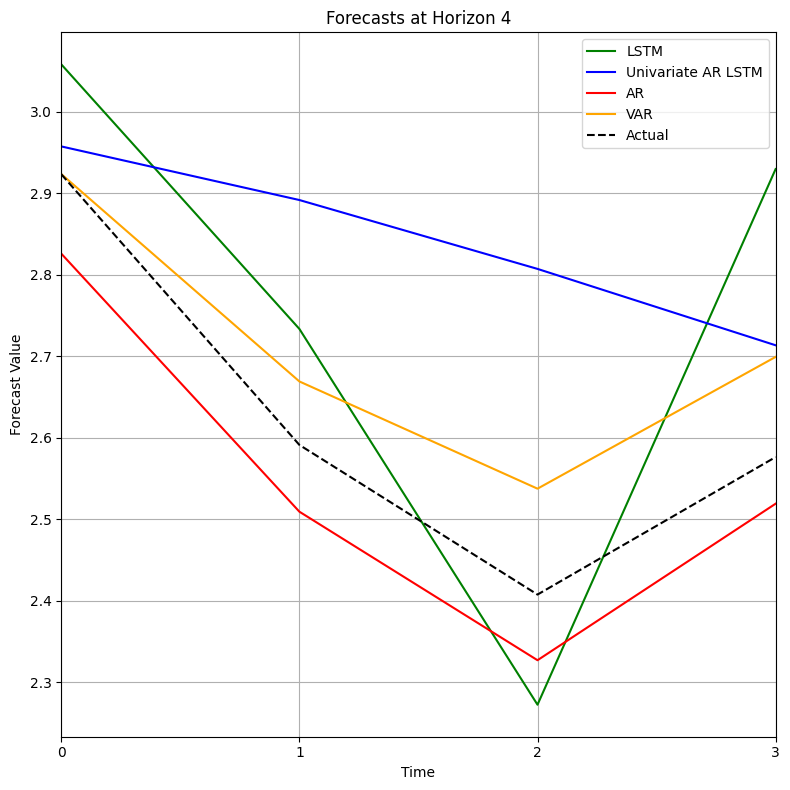

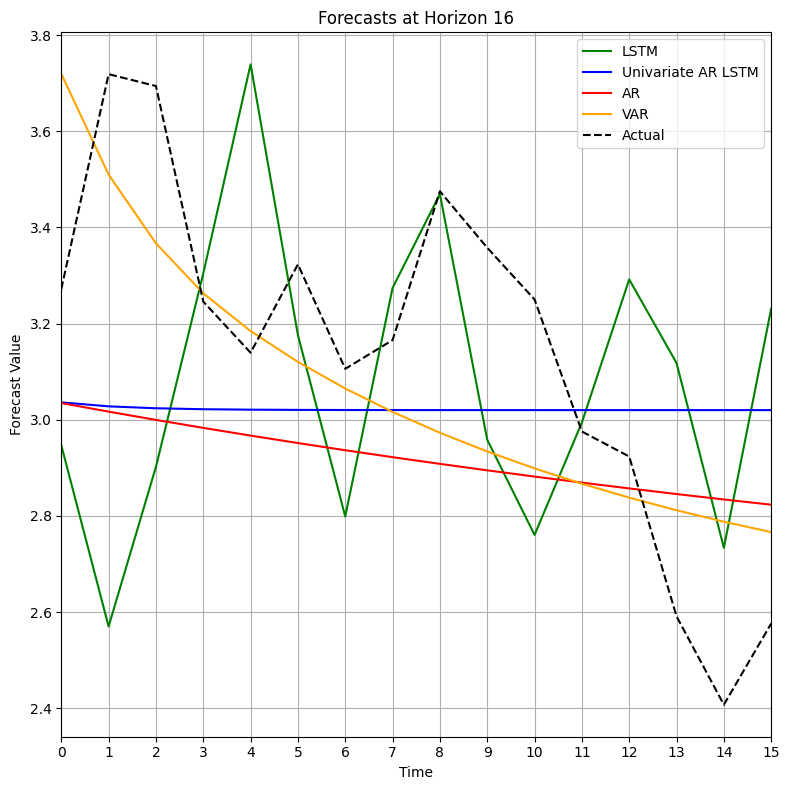

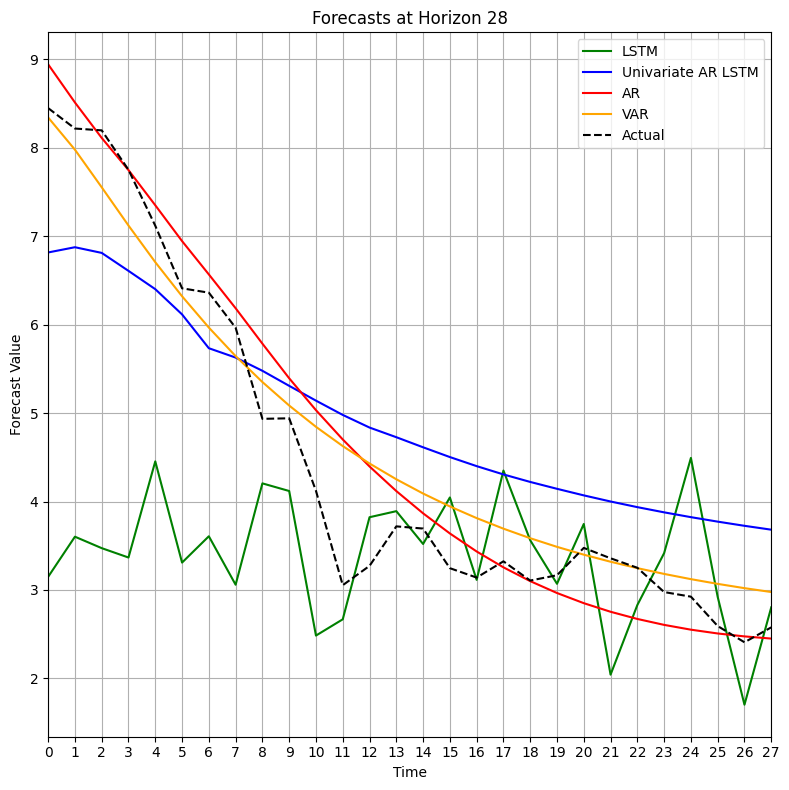

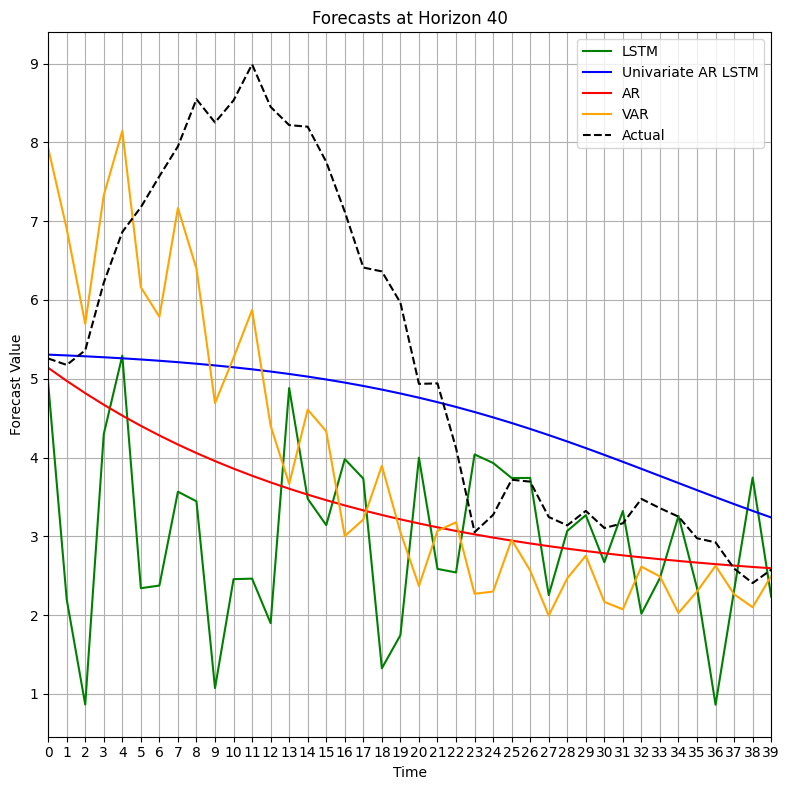

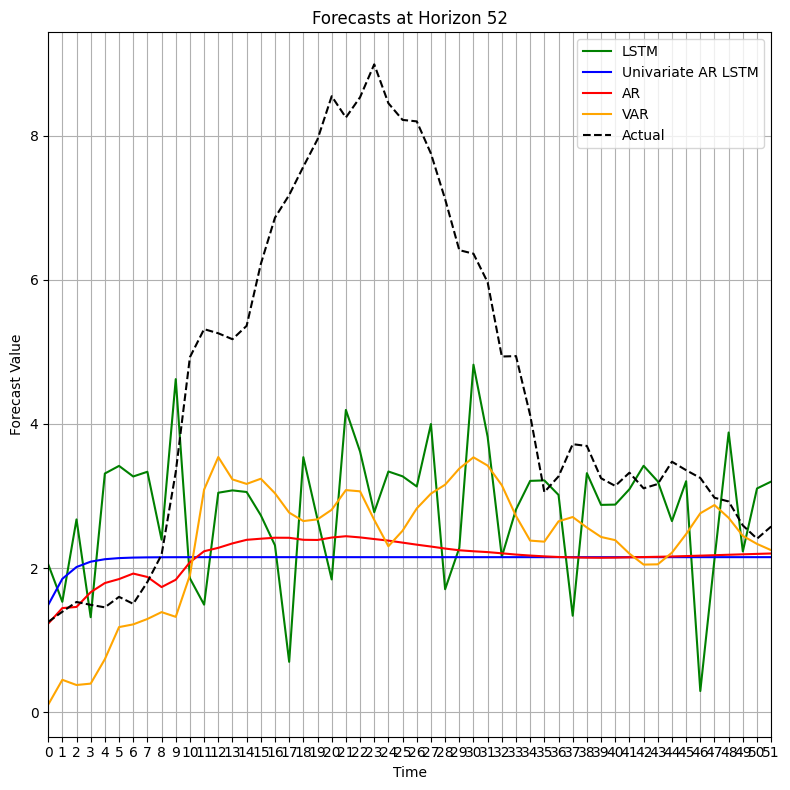

In [23]:
for horizon in [4, 16, 28, 40, 52]:
    plot_forecasts(horizon)